# Embedding and Filtering Inference 

Set default input and output directories according to local paths for data

In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

Import necessary libraries and functions

In [2]:
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
# import sympy
# from sympy import S, symbols, printing
# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial



In [3]:
noise_keep = ['0','0.2','0.4','0.6','0.8','1']
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 10,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})
noise_labels = [f'{float(n)*0.2*100:.0f}' for n in noise_keep]

## Adding Noise

In [4]:
def plot_noise_dist(noise_keeps):
    noise = []
    not_noise = []
    for i in noise_keeps:
        data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000"
        #data = torch.load(f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/feature_store_endcaps/n{i}/1000")
        data = torch.load(data_path)
        arr = data['pid']
        n_count = np.count_nonzero(arr==0)
        not_n = np.count_nonzero(arr)
        noise.append(n_count)
        not_noise.append(not_n)
        print("-----")
        print(data)

    x = np.arange(len(noise_keeps))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10,5))
    rects1 = ax.bar(x - width/2, noise, width, label='noise')
    rects2 = ax.bar(x + width/2, not_noise, width, label='not noise')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('# of hits')
    ax.set_xlabel('Percentage Noise')
    ax.set_xticks(x)
    ax.set_xticklabels(noise_labels)
    ax.legend()
    
    fig2, ax2 = plt.subplots(figsize=(10,5))
    ax2.plot(x,noise, label='noise')
    ax2.set_ylabel('# of hits')
    ax2.set_xlabel('Percentage Noise')
    ax2.set_xticks(x)
    ax2.set_xticklabels(noise_labels)
    ax2.legend()
    
    fig3, ax3 = plt.subplots(figsize=(10,5))
    ax3.plot(x,not_noise, label='not noise')
    ax3.set_ylabel('# of hits')
    ax3.set_xlabel('Percentage Noise')
    ax3.set_xticks(x)
    ax3.set_xticklabels(noise_labels)
    ax3.legend()

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all/event000001000", hid=[106831], layerless_true_edges=[2, 123429], layers=[103305], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001000", hid=[110358], layerless_true_edges=[2, 123429], layers=[103305], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_100_events/event000001000", hid=[113885], layerless_true_edges=[2, 123429], layers=[103305], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/projectdirs/atlas/xju/heptrkx/tr

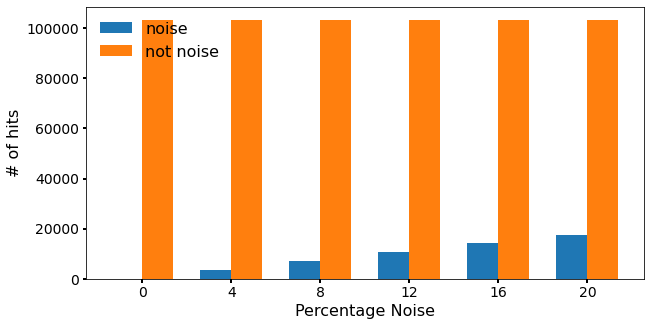

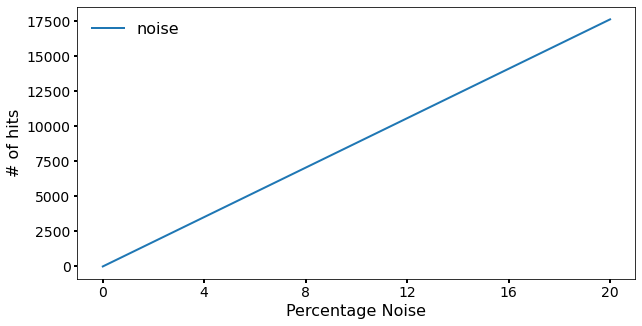

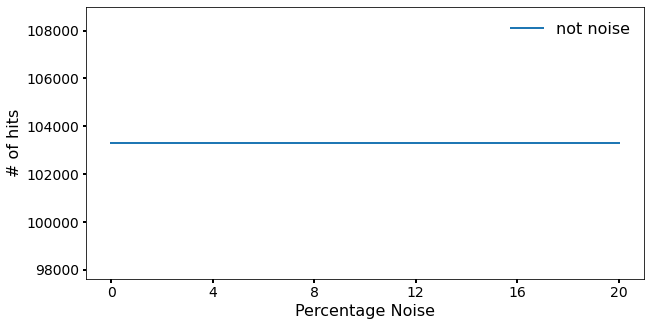

In [5]:
noise_keep = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
plot_noise_dist(noise_keep)

In [6]:
data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000"
data = torch.load(data_path)
data['cell_data'][3]

tensor([10.0000,  0.4211,  0.6767,  0.7532,  0.3000,  0.2812,  0.3000,  0.6220,
         1.8316])

## Embedding

Set checkpoint and other directory paths

In [7]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1' # needs to change...

Fixing some parameters

In [8]:
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

Load embedding model from checkpoint

In [9]:
emb_ckpt = torch.load(embed_ckpt_dir, map_location='cpu')
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [10]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

Put model in evaluation state

In [11]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

Define embedding metrics (function gets metrics for one event)

In [12]:
def get_emb_metrics(data_path, emb_model,r_val=1.7,knn_val=500):
    ## exclude loading time
    data = torch.load(data_path)
    spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
    
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    e_spatial = utils_torch.build_edges(spatial, r_val, knn_val)
    
    ## takes time 
    e_spatial_np = e_spatial.cpu().numpy()
    
    # remove R dist from out to in
    R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2)
    
    e_spatial_np = e_spatial_np[:, (R_dist[e_spatial_np[0]] <= R_dist[e_spatial_np[1]])]
    e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
    e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial_np), e_bidir)
    
    cluster_true = len(data.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial_n[0])
    purity = cluster_true_positive/cluster_positive
    eff = cluster_true_positive/cluster_true
    
    print("-----------")
    print(f"cluster true = {cluster_true}")
    print(f"cluste true positive = {cluster_true_positive}")
    print(f"cluster positive = {cluster_positive}")
    print(f"purity = {purity}")
    print(f"efficiency = {eff}")
    
    return purity, eff

Metrics for one event and all noise configurations

In [13]:
# %%time
# p_all = []
# e_all = []

# for i in noise_keep:
#     mypath = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/1000"
#     p, e = get_emb_metrics(mypath, emb_model)
#     p_all.append(p)
#     e_all.append(e)

In [14]:
# e_all

In [15]:
# x = np.arange(len(noise_keep))
# fig1, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
# fig1.suptitle('Evt 1000')
# fig1.tight_layout(w_pad = 10)
# ax1.plot(x, p_all, label = 'True Positive / Positive')
# ax1.set_xlabel('Noise Percentage')
# ax1.set_ylabel('Purity')
# ax1.set_xticks(x)
# ax1.set_xticklabels(noise_labels)
# ax1.legend()

# ax2.plot(x, e_all, label = 'True Positive / True')
# ax2.set_xlabel('Noise Percentage')
# ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
# ax2.set_xticklabels(noise_labels)
# ax2.legend()


In [16]:
# fig2, ax = plt.subplots(figsize=(10,10))
# fig2.suptitle(f'Eventid 1000, All noise, rval=1.7, knn=500')
# colors = cm.viridis(np.linspace(0,5))
# for i,noise in enumerate(noise_keep):
#     ax.scatter(p_all[i],e_all[i], color = colors[i], label = f'{float(noise)*0.2*100:.0f}')
    
# z = np.polyfit(p_all, e_all, 2)
# f = np.poly1d(z)

# ax.plot(p_all,f(p_all), label='fit')

# ax.set_xlabel('Purity')
# ax.set_ylabel('Efficiency')
# ax.legend()
# z

In [17]:
# z


Average metrics for all events and all noise configurations

In [19]:
def get_lvl_emb(mypath,emb_model,r_val=1.7,knn_val=500):
    events = [f for f in listdir(mypath) if isfile(join(mypath, f))][:5]
    p_lvl = []
    e_lvl = []
    for evt in events:
        data_path = join(mypath,evt)
        p, e = get_emb_metrics(data_path, emb_model,r_val,knn_val) 
        p_lvl.append(p)
        e_lvl.append(e)
    
    return np.mean(p_lvl), np.mean(e_lvl)

In [21]:
p_avg = []
e_avg = []
for i in noise_keep:
    print(f"--------- {i} ---------")
    data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n{i}/feature_store/"
    p, e = get_lvl_emb(data_path,emb_model)
    p_avg.append(p)
    e_avg.append(e)

--------- 0 ---------
-----------
cluster true = 98107
cluste true positive = 95730
cluster positive = 6626809
purity = 0.014445866781432812
efficiency = 0.9757713516874433
-----------
cluster true = 104909
cluste true positive = 102231
cluster positive = 7849250
purity = 0.01302430168487435
efficiency = 0.9744731147947269
-----------
cluster true = 116478
cluste true positive = 113666
cluster positive = 9160203
purity = 0.012408676969276772
efficiency = 0.9758581019591682
-----------
cluster true = 118662
cluste true positive = 115783
cluster positive = 9178018
purity = 0.01261525091800866
efficiency = 0.975737809913873
-----------
cluster true = 103195
cluste true positive = 100664
cluster positive = 7188799
purity = 0.014002895337593944
efficiency = 0.9754736179078444
-----------
cluster true = 101780
cluste true positive = 99429
cluster positive = 7227341
purity = 0.013757341738822065
efficiency = 0.9769011593633327
-----------
cluster true = 134776
cluste true positive = 131302
cl

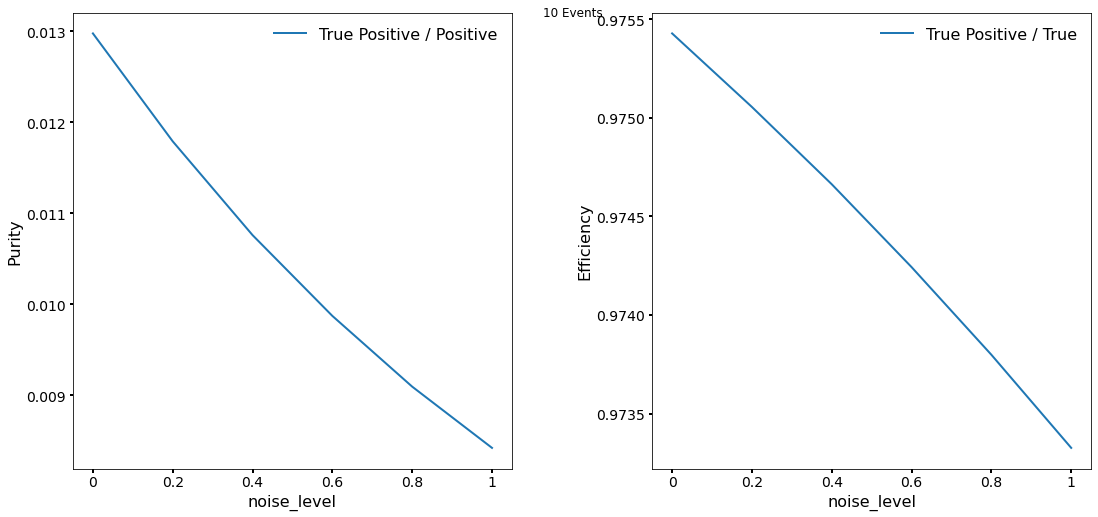

In [28]:
x = np.arange(len(noise_keep))
fig2, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig2.tight_layout(w_pad = 10)
fig2.suptitle('10 Events')
ax1.plot(x, p_avg, label = 'True Positive / Positive')
ax1.set_xlabel('noise_level')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_keep)
ax1.legend()

ax2.plot(x, e_avg, label = 'True Positive / True')
ax2.set_xlabel('noise_level')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_keep)
ax2.legend()

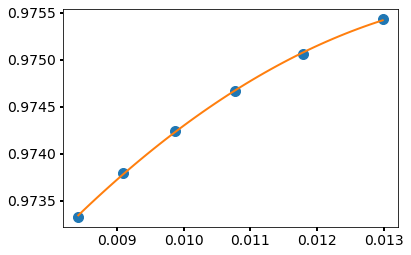

In [29]:
import scipy.optimize as opt


# calculate polynomial
z = np.polyfit(p_avg, e_avg, 2)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(p_avg[0], p_avg[-1], 50)
y_new = f(x_new)

plt.plot(p_avg,e_avg,'o', x_new, y_new)
plt.show()

Tuning Hyperparameters `r_val = 1.7` and `knn_val = 500` with a set level of noise for a specific event.

* `r_val` defines the radius of the clustering method
* `knn_val` defines the number of maximum neighbors in the embedding space

In [30]:
# noise_lvl = 1
# evtid = 1000
# set_event = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest/out{noise_lvl}/feature_store/{evtid}'

In [31]:
# import time
# from tqdm import tqdm
# rvals = np.arange(1,2,0.1)
# p_val = []
# e_val = []
# build_time = []
# for i in tqdm(range(len(rvals))):
#     data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000"
#     start = time.time()
#     pv, ev = get_emb_metrics(data_path, emb_model,rvals[i],500)
#     end = time.time()
#     print(end - start)
#     build_time.append(end-start)
#     p_val.append(pv)
#     e_val.append(ev)

In [32]:
%%time
import time
rvals = np.arange(1,2,0.1)
p_val = []
e_val = []
build_time = []
data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/"
events = [f for f in listdir(data_path) if isfile(join(data_path, f))][:5]

for n in rvals:
    print(f"--------- {n} ---------")
    #data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/1000"
    b = []
    p = []
    e = []
    for evt in events:
        evtpath = join(data_path,evt)
        start = time.time()
        pv, ev = get_emb_metrics(evtpath, emb_model,n,500)
        end = time.time()
        print(end - start)
        b.append(end-start)
        p.append(pv)
        e.append(ev)
    p_val.append(np.mean(p))
    e_val.append(np.mean(e))
    build_time.append(np.mean(b))

--------- 1.0 ---------
-----------
cluster true = 98107
cluste true positive = 85829
cluster positive = 723053
purity = 0.11870360817256827
efficiency = 0.8748509280683335
89.38341641426086
-----------
cluster true = 104909
cluste true positive = 91255
cluster positive = 816563
purity = 0.11175500236968856
efficiency = 0.8698491073215835
92.58813261985779
-----------
cluster true = 116478
cluste true positive = 101816
cluster positive = 937575
purity = 0.10859504572967496
efficiency = 0.8741221518226618
114.14114332199097
-----------
cluster true = 118662
cluste true positive = 103575
cluster positive = 922461
purity = 0.11228116961042256
efficiency = 0.8728573595590838
116.1138174533844
-----------
cluster true = 103195
cluste true positive = 90518
cluster positive = 770916
purity = 0.11741616466644875
efficiency = 0.877154900915742
93.91513848304749
--------- 1.1 ---------
-----------
cluster true = 98107
cluste true positive = 88958
cluster positive = 1118933
purity = 0.07950252606

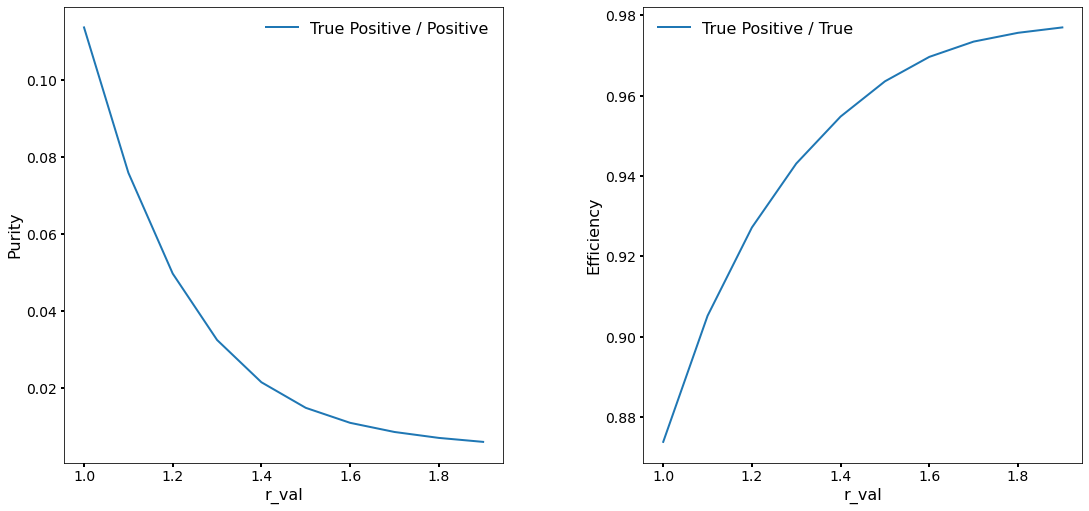

In [33]:
fig3, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
fig3.tight_layout(w_pad = 10)
# fig3.suptitle(f'Eventid {evtid}')
ax1.plot(rvals, p_val, label = 'True Positive / Positive')
ax1.set_xlabel('r_val')
ax1.set_ylabel('Purity')
# ax1.set_xticks(rvals)
ax1.legend()

ax2.plot(rvals, e_val, label = 'True Positive / True')
ax2.set_xlabel('r_val')
ax2.set_ylabel('Efficiency')
# ax2.set_xticks(x)
ax2.legend()

array([-55.39235269,  12.45937026,  -1.69294847,   0.98658249])

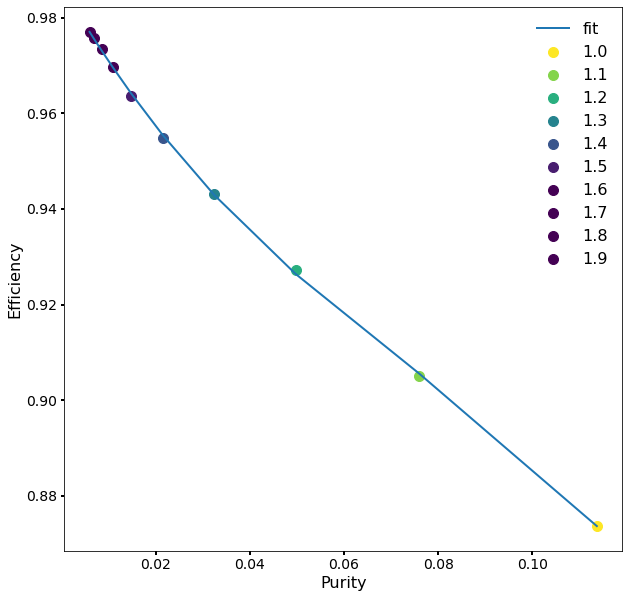

In [34]:
fig4, ax = plt.subplots(figsize=(10,10))
# fig4.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_val)-1
colors = cm.viridis_r(np.linspace(0,n))
for i,val in enumerate(rvals):
    ax.scatter(p_val[i],e_val[i], color = colors[i], label = f'{val:.1f}')
    
z = np.polyfit(p_val, e_val, 3)
f = np.poly1d(z)

ax.plot(p_val,f(p_val), label='fit')

ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()
z

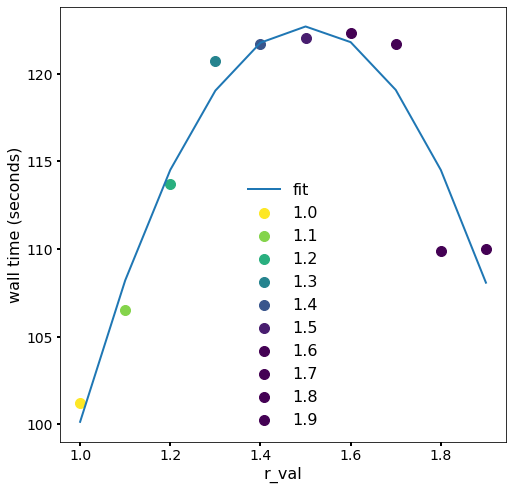

array([ -2.14827221, -81.28346268, 258.53022926, -74.96093921])

In [35]:
fig121, ax121 = plt.subplots(1,1,figsize=(8,8))
colors = cm.viridis_r(np.linspace(0,len(rvals)-1))
for i,r in enumerate(rvals):
    ax121.scatter(rvals[i],build_time[i],color = colors[i],label=f'{rvals[i]:.1f}')
    ax121.set_xlabel('r_val')
    ax121.set_ylabel('wall time (seconds)')
    ax121.legend()
    
z = np.polyfit(rvals,build_time, 3)
f = np.poly1d(z)

ax121.plot(rvals,f(rvals), label='fit')
ax121.legend()
    
plt.show()
z

In [36]:
rvals

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

In [37]:
build_time

[101.2283296585083,
 106.52447962760925,
 113.70346126556396,
 120.73566842079163,
 121.71541228294373,
 122.02150006294251,
 122.29829668998718,
 121.7177668094635,
 109.883789396286,
 110.0041928768158]

In [31]:
%%time
import time
step = np.arange(400,500,10)
p_kval = []
e_kval = []
k_time = []

data_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store/"
events = [f for f in listdir(data_path) if isfile(join(data_path, f))][:5]
    
for n in step:
    print(f"--------- {n} ---------")
    k = []
    p = []
    e = []
    for evt in events:
        evtpath = join(data_path,evt)
        start = time.time()
        pv, ev = get_emb_metrics(evtpath, emb_model,1.7,n.item())
        end = time.time()
        print(end - start)
        k.append(end-start)
        p.append(pv)
        e.append(ev)
    p_kval.append(np.mean(p))
    e_kval.append(np.mean(e))
    k_time.append(np.mean(k))

--------- 400 ---------
-----------
cluster true = 98107
cluste true positive = 95383
cluster positive = 10012578
purity = 0.009526317797474336
efficiency = 0.9722343971378189
106.71507549285889
-----------
cluster true = 104909
cluste true positive = 101775
cluster positive = 11235370
purity = 0.009058446673318279
efficiency = 0.9701264905775482
116.26516890525818
-----------
cluster true = 116478
cluste true positive = 113171
cluster positive = 12470539
purity = 0.009075068848267104
efficiency = 0.9716083723965041
137.12152552604675
-----------
cluster true = 118662
cluste true positive = 115263
cluster positive = 12535728
purity = 0.009194759171545521
efficiency = 0.9713556151084594
139.9547417163849
-----------
cluster true = 103195
cluste true positive = 100269
cluster positive = 10606151
purity = 0.00945385371186965
efficiency = 0.971645913077184
119.18040084838867
--------- 410 ---------
-----------
cluster true = 98107
cluste true positive = 95399
cluster positive = 10116420
pu

In [32]:
k_time

[123.84738249778748,
 121.6668447971344,
 121.91501927375793,
 119.3559072971344,
 99.62069535255432,
 110.3868579864502,
 108.00671725273132,
 107.97725367546082,
 110.39356665611267,
 123.23929471969605]

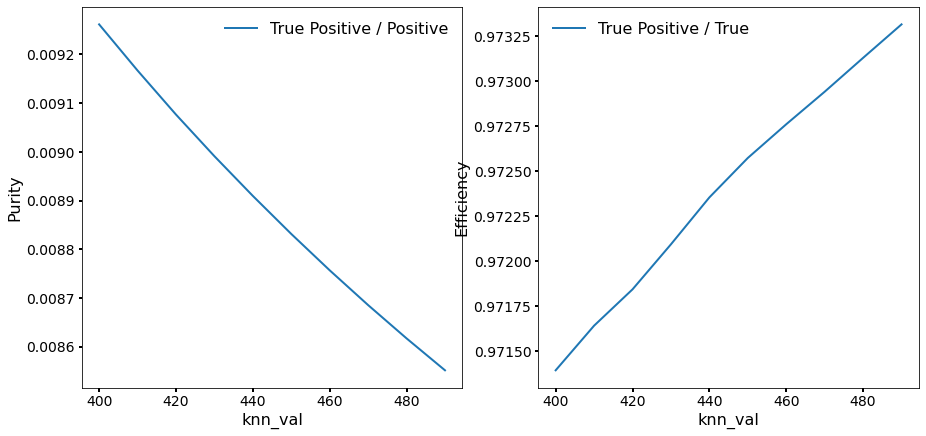

In [33]:
fig5, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7))
# fig5.suptitle(f'Eventid {evtid}, 100% noise, rval=1.7, 400,knnval,500')
ax1.plot(step, p_kval, label = 'True Positive / Positive')
ax1.set_xlabel('knn_val')
ax1.set_ylabel('Purity')
ax1.legend()

ax2.plot(step, e_kval, label = 'True Positive / True')
ax2.set_xlabel('knn_val')
ax2.set_ylabel('Efficiency')
ax2.legend()

array([49.11127789, -3.6019136 ,  1.00052762])

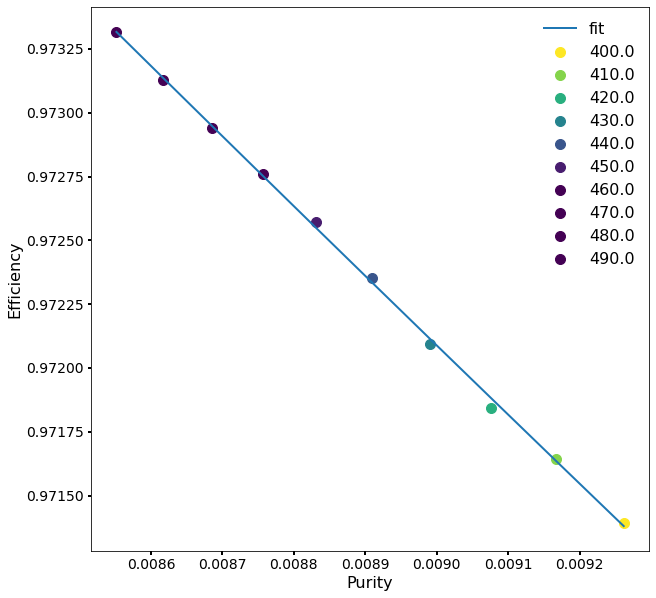

In [34]:
fig6, ax = plt.subplots(figsize=(10,10))
# fig6.suptitle(f'Eventid {evtid}, 100% noise, 1<rval<2, knn=500')
n = len(p_kval)-1
colors = cm.viridis_r(np.linspace(0,n))
for i,val in enumerate(step):
    ax.scatter(p_kval[i],e_kval[i], color = colors[i], label = f'{val:.1f}')
    
z = np.polyfit(p_kval, e_kval, 2)
f = np.poly1d(z)

ax.plot(p_kval,f(p_kval), label='fit')

ax.set_xlabel('Purity')
ax.set_ylabel('Efficiency')
ax.legend()
z

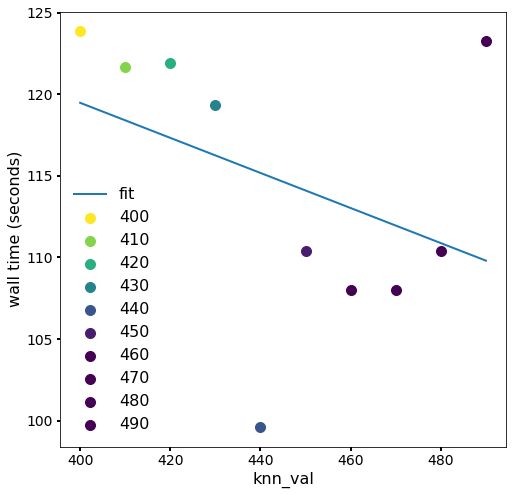

array([-1.07488468e-01,  1.62473322e+02])

In [35]:
fig121, ax121 = plt.subplots(1,1,figsize=(8,8))
colors = cm.viridis_r(np.linspace(0,len(step)-1))
for i,r in enumerate(step):
    ax121.scatter(step[i],k_time[i],color = colors[i],label=f'{step[i]:.0f}')
    ax121.set_xlabel('knn_val')
    ax121.set_ylabel('wall time (seconds)')
    ax121.legend()
    
z = np.polyfit(step,k_time, 1)
f = np.poly1d(z)

ax121.plot(step,f(step), label='fit')
ax121.legend()
    
plt.show()
z